In [1]:
import numpy as np
import glob, os
from keras import layers as ly
from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.layers import Input, Lambda
from keras import losses
from keras.models import model_from_json
import keras.backend.tensorflow_backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
import string

Using TensorFlow backend.


In [2]:
#dir = './sequence/*'
dir = './datasets/latest_seq/bfs-character/*'

In [3]:
# file read
all_names = []
all_data = []
sequence_length = []
alpha = list(string.ascii_uppercase)
data_length = len(glob.glob(dir))
file_predix = './datasets/latest_seq/bfs-character/graph'
for index in range(data_length):
    filename = file_predix + str(index) + "-*"
    files = glob.glob(filename)
    for file in files:
        datasets = []
        all_names.append(file.split('/')[-1].replace('.txt', ''))
        for rf in open(file, 'r'):
            (u, v, w) = rf[1:-2].split(', ')
            datasets.append([alpha.index(u[1])+1, alpha.index(v[1]) +1, float(w)])
        sequence_length.append(len(datasets))
        all_data.append(datasets)
all_data = np.array([np.array(arr) for arr in all_data])

In [4]:
x_train, x_test, train_name, test_name = train_test_split(all_data, all_names, test_size=0.3)
x_test, x_val, test_name, val_name = train_test_split(x_test, test_name, test_size=0.33)

In [5]:
train_name
tr_names= []
for name in train_name:
    tr_names.append(name.split('-')[0].replace('graph', ''))

In [6]:
max_sequence_length = max(sequence_length)
n_features = 3
batch_size = 32
epochs = 200
steps_per_epoch = len(x_train)

In [7]:
def custom_loss(y_true, y_pred):
    loss1 = losses.mean_squared_error(y_true, y_pred)
    loss2 = losses.kld(y_true, y_pred) # categorical_crossentropy
    return loss1 * 0.7 + loss2 * 0.3

In [8]:
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)
    

inputs = Input(shape=(None, 3))
encoded = LSTM(128, return_sequences=True)(inputs)  #activation 안적으면 tanh
encoded = LSTM(64)(encoded)

decoded = Lambda(repeat_vector, output_shape=(None, 64)) ([encoded, inputs]) # inputs의 shape[1] 만큼 encoded 를 반복 생성

decoded = LSTM(64, return_sequences=True)(decoded)
decoded = LSTM(128, return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(3))(decoded)
encoder = Model(inputs, encoded)

lstm_autoencoder = Model(inputs, decoded)
lstm_autoencoder.compile(loss=custom_loss, optimizer=Adam())#decay=0.9
#lstm_autoencoder_500 = lstm_autoencoder

W1018 14:49:21.282840 140188255131392 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1018 14:49:21.298787 140188255131392 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1018 14:49:21.301094 140188255131392 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1018 14:49:21.792530 140188255131392 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1018 14:49:21.798334 14

In [9]:
def val_generator(x_val):
    idx = 0
    while True:
        yield np.array([x_val[idx]]), np.array([x_val[idx]])
        idx += 1
        if idx >= len(x_val):
            idx = 0

def train_generator(x_train):
    idx = 0
    while True:
        yield np.array([x_train[idx]]), np.array([x_train[idx]])
        idx += 1
        if idx >= len(x_train):
            idx = 0

In [10]:
hist = lstm_autoencoder.fit_generator(train_generator(x_train), epochs=300, steps_per_epoch=steps_per_epoch, verbose=1, validation_steps=len(x_val), validation_data=val_generator(x_val))

W1018 14:49:21.972902 140188255131392 deprecation.py:323] From /home/minji/anaconda3/envs/graph/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1018 14:49:23.293820 140188255131392 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/300
4914/4914 [==============================] - 48s 10ms/step - loss: 32.6924 - val_loss: 13.9576
Epoch 2/300
4914/4914 [==============================] - 46s 9ms/step - loss: 12.4890 - val_loss: 10.6279
Epoch 3/300
4914/4914 [==============================] - 46s 9ms/step - loss: 10.1235 - val_loss: 8.7866
Epoch 4/300
4914/4914 [==============================] - 46s 9ms/step - loss: 8.6645 - val_loss: 7.5640
Epoch 5/300
4914/4914 [==============================] - 46s 9ms/step - loss: 7.7979 - val_loss: 7.1754
Epoch 6/300
4914/4914 [==============================] - 46s 9ms/step - loss: 6.8902 - val_loss: 6.0163
Epoch 7/300
4914/4914 [==============================] - 46s 9ms/step - loss: 5.8457 - val_loss: 4.9175
Epoch 8/300
4914/4914 [==============================] - 46s 9ms/step - loss: 4.6545 - val_loss: 4.9037
Epoch 9/300
4914/4914 [==============================] - 46s 9ms/step - loss: 4.0800 - val_loss: 4.2875
Epoch 10/300
4914/4914 [==============================] - 

4914/4914 [==============================] - 41s 8ms/step - loss: 0.2463 - val_loss: 0.4109
Epoch 80/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.2336 - val_loss: 0.3963
Epoch 81/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.2326 - val_loss: 0.3944
Epoch 82/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.2468 - val_loss: 0.4430
Epoch 83/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.2203 - val_loss: 0.5161
Epoch 84/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.2308 - val_loss: 0.4073
Epoch 85/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.2189 - val_loss: 0.3940
Epoch 86/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.2178 - val_loss: 0.4250
Epoch 87/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.2204 - val_loss: 0.3908
Epoch 88/300
4914/4914 [==============================] - 41s 8ms/st

4914/4914 [==============================] - 41s 8ms/step - loss: 0.1418 - val_loss: 0.3137
Epoch 157/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.1529 - val_loss: 0.3076
Epoch 158/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.1359 - val_loss: 0.3229
Epoch 159/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.1432 - val_loss: 0.3663
Epoch 160/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.1446 - val_loss: 0.3247
Epoch 161/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.1472 - val_loss: 0.3457
Epoch 162/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.1362 - val_loss: 0.3756
Epoch 163/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.1319 - val_loss: 0.3289
Epoch 164/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.1451 - val_loss: 0.3293
Epoch 165/300
4914/4914 [==============================] - 4

4914/4914 [==============================] - 41s 8ms/step - loss: 0.1068 - val_loss: 0.3470
Epoch 234/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.1081 - val_loss: 0.3088
Epoch 235/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.1104 - val_loss: 0.2904
Epoch 236/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.1059 - val_loss: 0.2753
Epoch 237/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.1121 - val_loss: 0.3104
Epoch 238/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.1067 - val_loss: 0.2922
Epoch 239/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.1033 - val_loss: 0.3557
Epoch 240/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.1102 - val_loss: 0.3274
Epoch 241/300
4914/4914 [==============================] - 41s 8ms/step - loss: 0.1055 - val_loss: 0.3028
Epoch 242/300
4914/4914 [==============================] - 4

In [11]:
# MODEL SAVE
model_json = lstm_autoencoder.to_json()
filename = 'new_mse_kld_lstmae' #input('filename: ') 
with open('model_save/mse_kld_models/' + filename + '.json', 'w') as file:
    file.write(model_json)
lstm_autoencoder.save_weights('model_save/mse_kld_models/weights_' +  filename + '.h5')

In [14]:
import json
with open('model_save/mse_kld_models/new_kld_history.json', 'w') as f:
    json.dump(hist.history, f)

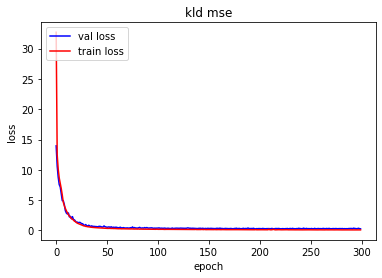

In [16]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['val_loss'], 'b', label='val loss')
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.title('kld mse')
plt.show()

In [17]:
loaded_model = lstm_autoencoder

In [18]:
mean= 0
for xt in x_test:
    xt = xt.reshape(1, xt.shape[0], xt.shape[1])
    out = loaded_model.predict(xt)
    mean += ((xt-out)**2).mean(axis=None)
print(mean/len(x_test))

0.38918926875524856


In [5]:
filename = "latest_mse_kld_lstmae1"
# MODEL LOAD
loaded_model = model_from_json(open('model_save/mse_kld_models/' +filename + '.json').read())
loaded_model.load_weights('model_save/mse_kld_models/weights_' + filename + '.h5')

W1017 20:05:39.672357 139985310242560 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1017 20:05:39.683409 139985310242560 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1017 20:05:39.685610 139985310242560 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1017 20:05:40.291379 139985310242560 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



In [ ]:
encoder = Model(loaded_model.input, loaded_model.layers[3].output)

In [ ]:
test = x_test[0].reshape(1, x_test[0].shape[0], x_test[0].shape[1])
latent_vector = []
for x in x_test:
    x = x.reshape(1, x.shape[0], x.shape[1])
    latent_vector.append(encoder.predict(x)[0])

In [23]:
model_path = 'model_save/mse_kld_models/weights' + '{epoch:02d}-{loss:.4f}.h5'
early_stopping_callback = EarlyStopping(monitor='loss', patience=200)
checkpoint_callback = ModelCheckpoint(model_path, monitor='loss', verbose = 1, save_best_only = True, save_weights_only = True, mode='min', period=100)